Now that we have the time dependent solution to a potential, we can generate the transition matrix, again we copy the
time evolving state from the previous tutorial.

In [1]:
from IPython.display import HTML
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
np.set_printoptions(precision=4, suppress=True)

from quantized.basis import HarmonicOscillator, EigenBasis
from quantized.operators import Hamiltonian, Overlap

from quantized.time_evolution import TimeEvolvingState, TimeEvolvingObservable

def potential(x):
    return -0.5*x**2 + 0.04 * x**4 + 2

basis = [
    HarmonicOscillator(n=0, center=-2),
    HarmonicOscillator(n=1, center=-2), 
    HarmonicOscillator(n=0, center=2), 
    HarmonicOscillator(n=1, center=2),
]

H = Hamiltonian(potential).matrix(basis)
S = Overlap().matrix(basis)

eig_basis = EigenBasis.from_basis(basis, H, S)
initial = HarmonicOscillator(n=1, center=-2)
time_state = TimeEvolvingState(initial, eig_basis)

Now that we have a time evolving state, we can calculate the occupancy probabilities
for each spatial region over time. This has been incorporated into the libary.

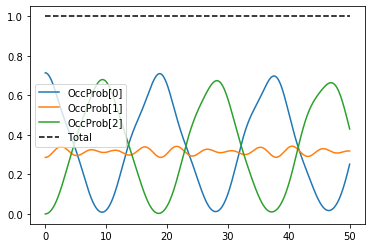

In [2]:
from quantized.hopping_matrix import HoppingMatrix, OccupancyProbabilites


occ_probs = OccupancyProbabilites.from_1d_state(time_state, borders=(-np.inf, -1, 1, np.inf))

t = np.linspace(0, 50, 1000)

fig, ax = plt.subplots()

for i, op in enumerate(occ_probs(t)):
    ax.plot(t, op, label=f"OccProb[{i}]")

ax.plot(t, sum(occ_probs(t)), "k--", label="Total")

_ = ax.legend()

Here We've included the probability of occupancy for each of the regions, region 0 :$(-\infty, -1]$ region 1:  $(-1, 1)$ and region 2:  $[1, \infty)$
as is shown in the figure above, the total occupancy probability is simply 1.0, which means the particle has probability 1 of existing anywhere, 
as it should. Next we calculate the transition matrix over time. The transition matrix element $A_{i, j}$is basically
the amount of probability density that hops from region $j$ to region $i$ within the timespan $\Delta t$. More details
can be found in [the paper](https://www.worldscientific.com/doi/10.1142/S0219633618500463). Let's take a look at this matrix
over time:

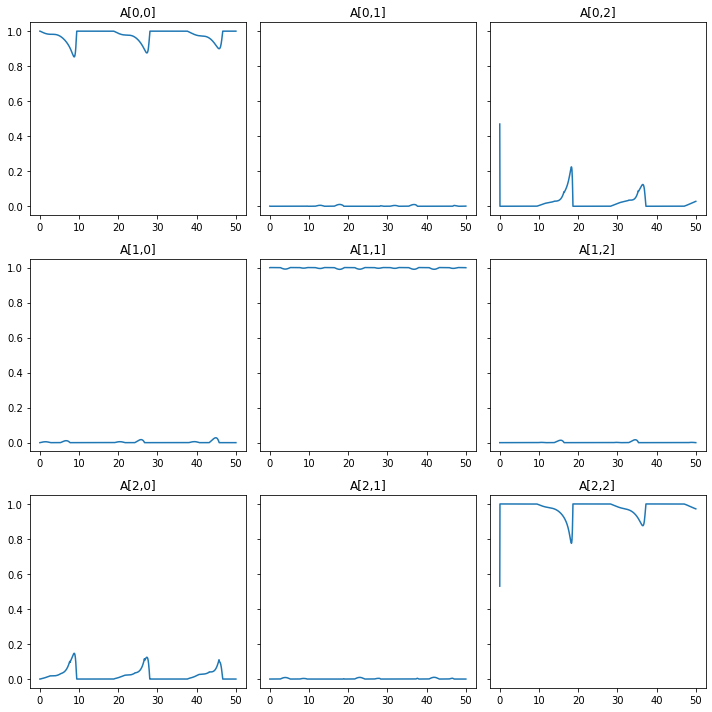

In [3]:
from quantized.plotting import plot_matrix
from functools import partial


A = HoppingMatrix(occ_probs)
fig, ax = plot_matrix(partial(A, delta_t=0.1), t, name="A", figsize=(10, 10), sharey=True)
fig.tight_layout()

Here it's clear that the matrix is close to 1 on the diagonals for most of the time. This means
that within each region, the probability density is not likely to move to another region. Some
of the density does leak, however. If you look at the densities between the two wells, 
you'll see that there is an oscillation from one well to the other that corresponds exactly to 
the oscillation period of the density. This system is quite interesting, since there's symmetry about the center.
The transition matrix elements for the central portion of the potential are almost static.



We are now ready to determine the Pnot, again for details you can read the paper. 
One of the reasons we do this approach that we've chosen is to be able to converge
this quantity with respect to reducing the timestep. To do this, we calculate 
Pnot, while convergint the time step:

In [4]:
from quantized.hopping_matrix import Pnot

pnot = Pnot.converged_with_timestep(A, acceptor=2, until_equals=0.1, tolerance=0.01)

2020-01-11 14:45:04.104 | INFO     | quantized.hopping_matrix:converged_with_timestep:270 - For delta_t = 1.00000, Tau = 79.15706
2020-01-11 14:45:04.158 | INFO     | quantized.hopping_matrix:converged_with_timestep:270 - For delta_t = 0.62112, Tau = 75.83543
2020-01-11 14:45:04.232 | INFO     | quantized.hopping_matrix:converged_with_timestep:270 - For delta_t = 0.38579, Tau = 74.54280
2020-01-11 14:45:04.321 | INFO     | quantized.hopping_matrix:converged_with_timestep:270 - For delta_t = 0.23962, Tau = 64.30697
2020-01-11 14:45:04.449 | INFO     | quantized.hopping_matrix:converged_with_timestep:270 - For delta_t = 0.14883, Tau = 62.98531
2020-01-11 14:45:04.619 | INFO     | quantized.hopping_matrix:converged_with_timestep:270 - For delta_t = 0.09244, Tau = 62.57651
2020-01-11 14:45:04.898 | INFO     | quantized.hopping_matrix:converged_with_timestep:270 - For delta_t = 0.05742, Tau = 62.36069
2020-01-11 14:45:05.327 | INFO     | quantized.hopping_matrix:converged_with_timestep:270 

Lovely! We've converged Pnot up to `0.1 +/- 0.01` by choosing a delta_t of `0.00330`. Let's get a visualization of this thing.
The below code is basically all for the visualization, so only pay attention to the video.

In [5]:
%%capture
from quantized.plotting import animate_pnot_and_matrix


ani = animate_pnot_and_matrix(
    potential=potential, 
    initial=initial, 
    initial_energy=initial.energy, 
    time_state=time_state, 
    pnot=pnot, 
    occ_probs=occ_probs
)

In [6]:
HTML(ani.to_html5_video())

So on the left we can see that the density is oscillating between the left (donor) and right (acceptor) wells.
The middle plot shows the probability density evolving over time. The right plot shows how the probability
of not having sampled the right well changes over time. Notice how this quantity evovles under the assumption
of least flow. `Pnot` decreases as the density shifts to the acceptor well. However, as soon as density
begins to leave the acceptor well, it flatlines. This is due to the least flow assumption. As the density
starts to shift back, `Pnot` decreases yet again, but less this time. This pattern repeats itself until
`Pnot` eventually tends to zero.